In [717]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
from sklearn.ensemble import RandomForestClassifier

In [658]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


In [659]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [660]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


Just checking how many women survived compared to men

<Axes: xlabel='Sex'>

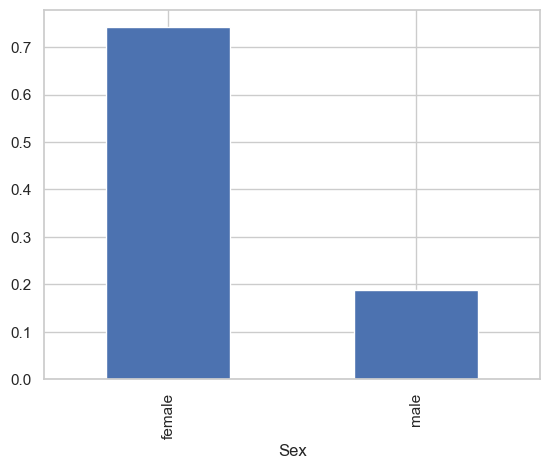

In [661]:
train.groupby('Sex').Survived.mean().plot(kind='bar')

In [662]:
train.isnull().sum()#checking nulls in train

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

There are null values in Age, Cabin, Embarked in the training data

In [663]:
test.isnull().sum()#checking nulls in test

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [664]:
test.loc[test['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


I think here I would average the values of passengers with similar other values and fill in the Fare.
or maybe the median idk which is better. For now i will avergage values of similar passengers. This average value will be taken from the training set.

In [665]:
train.loc[(train['Age'] >= 60) & (train['Pclass'] == 3) & (train['Sex'] == 'male') & (train['SibSp'] == 0) & (train['Parch'] == 0) & (train['Embarked'] == 'S')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
326,327,0,3,"Nysveen, Mr. Johan Hansen",male,61.0,0,0,345364,6.2375,NaN,S
851,852,0,3,"Svensson, Mr. Johan",male,74.0,0,0,347060,7.7750,NaN,S


I manually found the average of the fare to be around 7.00625 so i am just going to use that value for the null value in test.

In [666]:
test.loc[test['Fare'].isnull(), 'Fare'] = 7.00625

In [667]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64

now we have no nulls in the fare column.

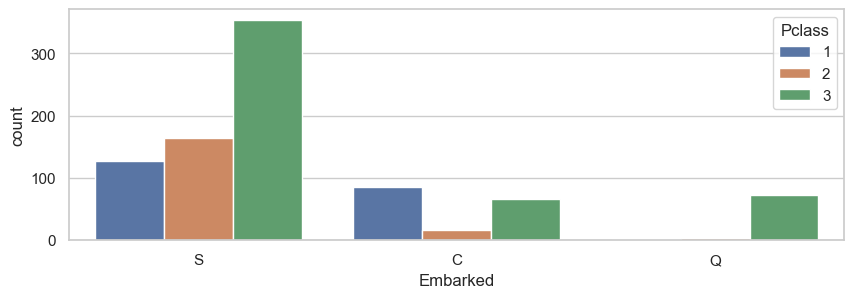

In [668]:
train1 = train[0:891].copy()
sns.set(style="whitegrid")
plt.figure(figsize=(10,3))
ax = sns.countplot(x="Embarked",hue='Pclass', data=train1)


Now to fix all the null values in the Training set. Age , Cabin, Embarked
Start with Cabin.

In [669]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [670]:
train.drop(['Cabin', 'PassengerId'], axis=1, inplace=True)
#removing passenger id and cabin as they dont contribute to the survival rate

In [671]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


most common embarked is S and replacing all values of missing embarked as S.

In [672]:
train["Embarked"] = train["Embarked"].fillna('S')

In [673]:
missing_age = train['Age'].isnull().sum()

if missing_age > 0:
    # Calculate the mean age (you can replace 'mean' with 'median' or 'mode' if you prefer)
    mean_age = train['Age'].mean()

    # Fill missing values in the 'Age' column with the mean age
    train['Age'].fillna(mean_age, inplace=True)

    # Verify that there are no missing values after filling
    updated_missing_age = train['Age'].isnull().sum()
    print(f"Missing values in 'Age' column before: {missing_age}")
    print(f"Missing values in 'Age' column after filling: {updated_missing_age}")
else:
    print("No missing values in the 'Age' column.")

Missing values in 'Age' column before: 177
Missing values in 'Age' column after filling: 0


In [674]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 69.7+ KB


In [675]:
test.drop(['Cabin', 'PassengerId'], axis=1, inplace=True)

In [676]:
missing_age = test['Age'].isnull().sum()

if missing_age > 0:
    # Calculate the mean age (you can replace 'mean' with 'median' or 'mode' if you prefer)
    mean_age = test['Age'].mean()

    # Fill missing values in the 'Age' column with the mean age
    test['Age'].fillna(mean_age, inplace=True)

    # Verify that there are no missing values after filling
    updated_missing_age = test['Age'].isnull().sum()
    print(f"Missing values in 'Age' column before: {missing_age}")
    print(f"Missing values in 'Age' column after filling: {updated_missing_age}")
else:
    print("No missing values in the 'Age' column.")

Missing values in 'Age' column before: 86
Missing values in 'Age' column after filling: 0


In [677]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       418 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      418 non-null    float64
 8   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(4)
memory usage: 29.5+ KB


There are string values that need to be fixed here such as embarked. By ressearch i found that i can use Labelencoder from sklearn to encode these values to float to use in the model.

In [678]:
#For testing only

le1 = LabelEncoder()
train["Embarked"]= le1.fit_transform(train["Embarked"])
print(train["Embarked"])

0      2
1      0
2      2
3      2
4      2
      ..
886    2
887    2
888    2
889    0
890    1
Name: Embarked, Length: 891, dtype: int32


In [679]:

le2 = LabelEncoder()
train["Sex"]= le2.fit_transform(train["Sex"])
print(train["Sex"])

0      1
1      0
2      0
3      0
4      1
      ..
886    1
887    0
888    0
889    1
890    1
Name: Sex, Length: 891, dtype: int32


In [680]:
le3 = LabelEncoder()
test["Embarked"]= le3.fit_transform(test["Embarked"])
print(test["Embarked"])

0      1
1      2
2      1
3      2
4      2
      ..
413    2
414    0
415    2
416    2
417    0
Name: Embarked, Length: 418, dtype: int32


In [681]:
le4 = LabelEncoder()
test["Sex"]= le4.fit_transform(test["Sex"])
print(test["Sex"])

0      1
1      0
2      1
3      1
4      0
      ..
413    1
414    0
415    1
416    1
417    1
Name: Sex, Length: 418, dtype: int32


In [682]:

#going to drop ticket too as the values in the testing and training data for the ticket are different
test.drop(['Ticket','Name'], axis=1, inplace=True)
train.drop(['Ticket','Name'], axis=1, inplace=True)

In [683]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    int32  
 2   Age       418 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      418 non-null    float64
 6   Embarked  418 non-null    int32  
dtypes: float64(2), int32(2), int64(3)
memory usage: 19.7 KB


In [684]:
from sklearn.preprocessing import StandardScaler
y_train = train['Survived'].values
x_train = ['Pclass', 'Age','SibSp', 'Parch', 'Fare', 'Embarked','Sex']
x_test = ['Pclass', 'Age','SibSp', 'Parch', 'Fare', 'Embarked','Sex']
scaler = StandardScaler()
dfScaled1 = scaler.fit_transform(train[x_train])
dfScaled2 = scaler.fit_transform(test[x_test])
x_train = dfScaled1[0:891].copy()
x_test = dfScaled2[0:418].copy()

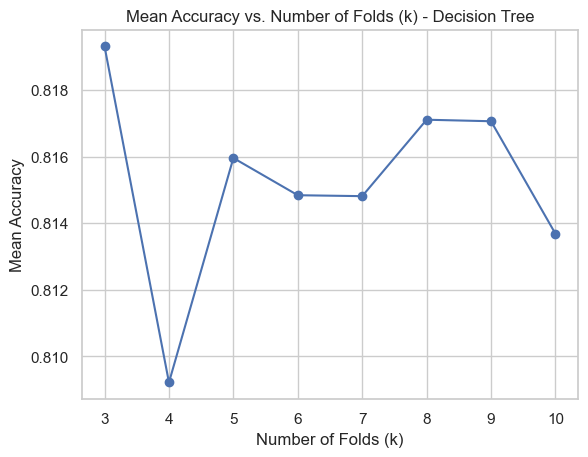

In [734]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_leaf=1, min_samples_split=4, random_state=20)

# Define a range of k values for cross-validation
k_values = range(3, 11)
mean_scores = []

for k in k_values:
    # Create a KFold object with k folds
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    # Perform cross-validation and get the accuracy scores
    cv_scores = cross_val_score(dtc, x_train, y_train, cv=kf, scoring='accuracy')
    
    # Calculate the mean accuracy and store it
    mean_accuracy = np.mean(cv_scores)
    mean_scores.append(mean_accuracy)

# Plot the results
plt.plot(k_values, mean_scores, marker='o')
plt.title('Mean Accuracy vs. Number of Folds (k) - Decision Tree')
plt.xlabel('Number of Folds (k)')
plt.ylabel('Mean Accuracy')
plt.show()


In [735]:

decision_tree = DecisionTreeClassifier(max_depth = 3)
decision_tree.fit(x_train, y_train)

# Predicting results for test dataset
y_pred = decision_tree.predict(x_test)
acc_decision_tree = round(decision_tree.score(x_train, y_train) * 100, 2)
acc_decision_tree

82.72

for the trees I have used the max depth of 3 that can be seen from the K fold cross validation that to least amount of over or underfit and maximum accuracy I need to use max depth of 3.

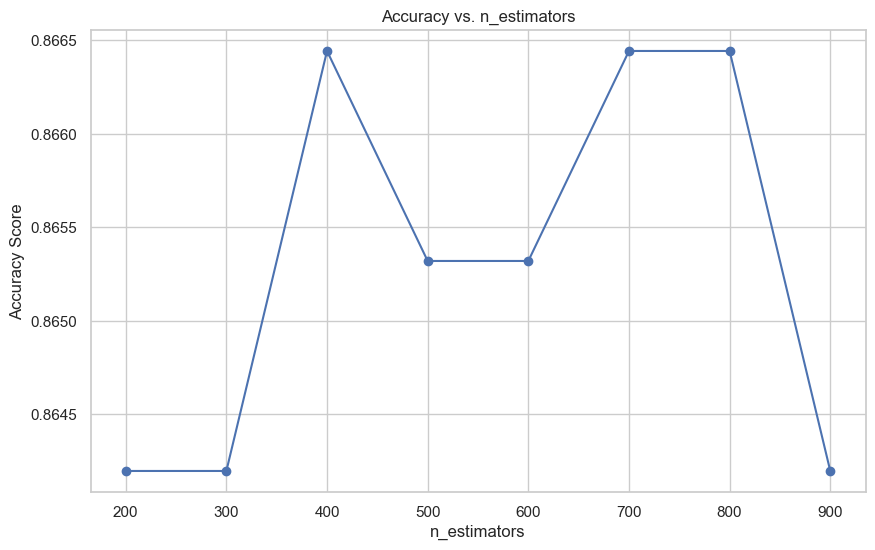

In [720]:
n_estimators_values = np.arange(200, 1000, 100)

# Initialize an empty list to store accuracy scores
accuracy_scores = []

# Loop through different n_estimators values
for n_estimators in n_estimators_values:
    RFc = RandomForestClassifier(
        bootstrap=True,
        class_weight=None,
        criterion='gini',
        max_depth=6,
        min_samples_split=4,
        min_weight_fraction_leaf=0.0,
        n_estimators=n_estimators,
        n_jobs=-1,
        oob_score=True,
        random_state=20,
        verbose=0,
        warm_start=False
    )
    
    # Fit the model
    RFc.fit(x_train, y_train)
    
    # Predict on the training set
    y_pred = RFc.predict(x_train)
    
    # Calculate accuracy and store it
    accuracy = accuracy_score(y_train, y_pred)
    accuracy_scores.append(accuracy)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_values, accuracy_scores, marker='o')
plt.title('Accuracy vs. n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy Score')
plt.grid(True)
plt.show()

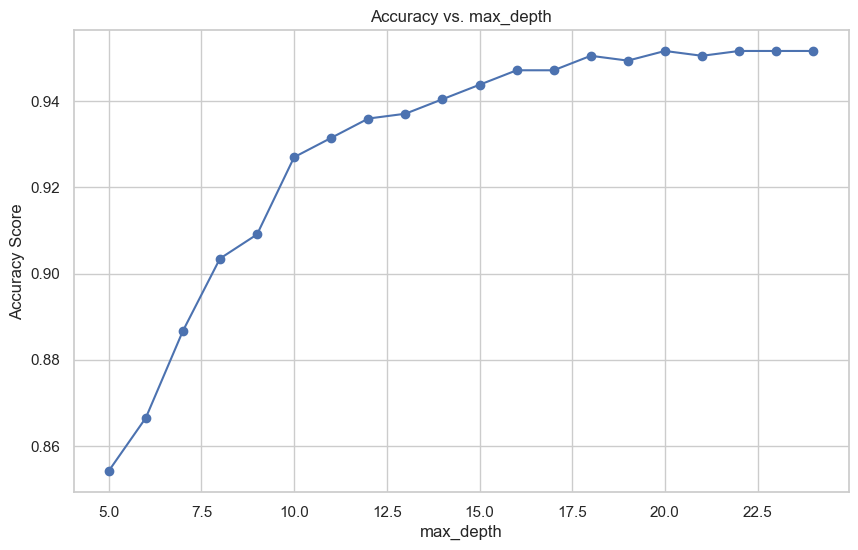

In [723]:
max_depth_values = np.arange(5, 25)

# Initialize an empty list to store accuracy scores
accuracy_scores = []

# Loop through different max_depth values
for max_depth in max_depth_values:
    RFc = RandomForestClassifier(
        bootstrap=True,
        class_weight=None,
        criterion='gini',
        max_depth=max_depth,
        max_leaf_nodes=None,
        min_samples_leaf=1,
        min_samples_split=4,
        min_weight_fraction_leaf=0.0,
        n_estimators=400,
        n_jobs=-1,
        oob_score=True,
        random_state=20,
        verbose=0,
        warm_start=False
    )
    
    # Fit the model
    RFc.fit(x_train, y_train)
    
    # Predict on the training set
    y_pred = RFc.predict(x_train)
    
    # Calculate accuracy and store it
    accuracy = accuracy_score(y_train, y_pred)
    accuracy_scores.append(accuracy)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, accuracy_scores, marker='o')
plt.title('Accuracy vs. max_depth')
plt.xlabel('max_depth')
plt.ylabel('Accuracy Score')
plt.grid(True)
plt.show()

As we can see the accuracy settles at around 20 max depth but that highly overfits the data when compared to the crossvalidation scores highly overfits the data so i will be keeping the max depth to 6 which is slightly overfit but is very close to the cross validation score

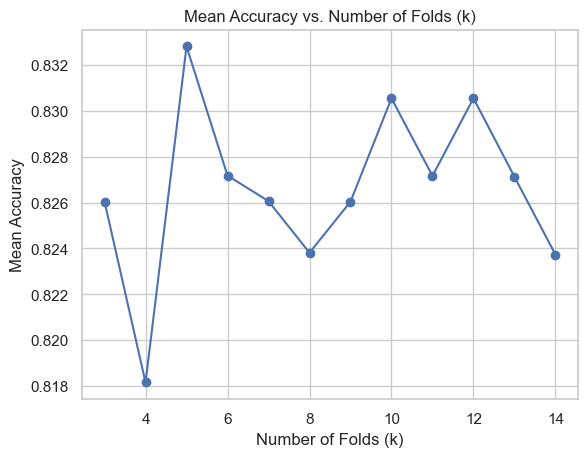

In [737]:
RFc = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                             max_depth=5, max_leaf_nodes=None,
                             min_samples_leaf=1, min_samples_split=4,
                             min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
                             oob_score=True, random_state=20, verbose=0, warm_start=False)

# Define a range of k values for cross-validation
k_values = range(3, 15)
mean_scores = []

for k in k_values:
    # Create a KFold object with k folds
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    # Perform cross-validation and get the accuracy scores
    cv_scores = cross_val_score(RFc, x_train, y_train, cv=kf, scoring='accuracy')
    
    # Calculate the mean accuracy and store it
    mean_accuracy = np.mean(cv_scores)
    mean_scores.append(mean_accuracy)

# Plot the results
plt.plot(k_values, mean_scores, marker='o')
plt.title('Mean Accuracy vs. Number of Folds (k)')
plt.xlabel('Number of Folds (k)')
plt.ylabel('Mean Accuracy')
plt.show()

We can see that the cross validation score highest for the max depth of 5 so that is what i am going to use to minimize the overfitting.

In [739]:

RFc = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
            oob_score=True, random_state=20, verbose=0, warm_start=False)
RFc.fit(x_train, y_train) 
y_test = RFc.predict(x_train)
accuracy_score(y_train,y_test)


0.8540965207631874

In [740]:

# Calculate the out-of-bag (OOB) score
oob_score = RFc.oob_score_
print(f'Out-of-Bag (OOB) Score: {oob_score}')

Out-of-Bag (OOB) Score: 0.8159371492704826


In [729]:
prdt2 = RFc.predict(x_test)   #using Random Forest Classifier
print('Predicted result: ', prdt2)

Predicted result:  [0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 0
 1 0 0 1 0 1 1 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 1 0 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 1 0 1 0 0 0]


In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='liblinear')
logreg.fit(x_train,y_train)
y_pred = logreg.predict(x_train)
accuracy_score(y_train,y_pred)


0.8013468013468014

In [ ]:
# Importing C-Support Vector Classification from scikit-learn
from sklearn.svm import SVC

# Declaring the SVC with no tunning
classifier = SVC()

# Fitting the data. This is where the SVM will learn
classifier.fit(x_train, y_train)

# Predicting the result and giving the accuracy
score = classifier.score(x_train, y_train)

print(score)

0.8383838383838383
